# 01_reviews

- length: review_title, review_positive, review_negative
- sentiment analysis of review_title

In [ ]:
import polars as pl
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from tqdm.notebook import tqdm
import torch
import gc
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
data_dir = "../../accommodation-reviews/rectour24/"

train_reviews = pl.read_csv(data_dir + "train_reviews.csv")
valid_reviews = pl.read_csv(data_dir + "val_reviews.csv")
test_reviews = pl.read_csv(data_dir + "test_reviews.csv")

## review_length

In [3]:
train_reviews = (
    train_reviews.with_columns(
        review_title_length=pl.col("review_title").str.split(" ").list.len(),
        review_positive_length=pl.col("review_positive").str.split(" ").list.len(),
        review_negative_length=pl.col("review_negative").str.split(" ").list.len(),
    )
)

valid_reviews = (
    valid_reviews.with_columns(
        review_title_length=pl.col("review_title").str.split(" ").list.len(),
        review_positive_length=pl.col("review_positive").str.split(" ").list.len(),
        review_negative_length=pl.col("review_negative").str.split(" ").list.len(),
    )
)

test_reviews = (
    test_reviews.with_columns(
        review_title_length=pl.col("review_title").str.split(" ").list.len(),
        review_positive_length=pl.col("review_positive").str.split(" ").list.len(),
        review_negative_length=pl.col("review_negative").str.split(" ").list.len(),
    )
)

In [4]:
train_reviews['review_positive_length'].max(), train_reviews['review_negative_length'].max()

(995, 969)

In [5]:
valid_reviews['review_positive_length'].max(), valid_reviews['review_negative_length'].max()

(401, 415)

In [6]:
test_reviews['review_positive_length'].max(), test_reviews['review_negative_length'].max()

(578, 382)

## Sentiment Analysis

Use [TimesLM](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

In [4]:
# model definition
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

model.config.use_cache = False
model.resize_token_embeddings(len(tokenizer))

/home/tokutake/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

Embedding(50265, 768, padding_idx=1)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [7]:
def sentiment_score(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(**encoded_input)
    scores = output.logits[0]
    scores = softmax(scores.cpu().numpy())  # Move to CPU before converting to numpy
    return scores


# Batch processing
def sentiment_score_batch(texts):
    preprocessed_texts = [preprocess(text) for text in texts]
    encoded_input = tokenizer(
        preprocessed_texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=514,
    ).to(device)

    with torch.no_grad():
        output = model(**encoded_input)
        scores = output.logits
        scores = softmax(scores.cpu().numpy(), axis=1)  # Move to CPU and apply softmax

    torch.cuda.empty_cache()
    del encoded_input
    gc.collect()

    return scores

In [8]:
# test
sentiment_score("Covid cases are increasing fast!")

array([0.72357684, 0.22867891, 0.04774426], dtype=float32)

In [ ]:
# Process in batches
batch_size = 256  # Adjust this based on your GPU memory capacity
review_title_scores = []

for i in tqdm(range(0, len(train_reviews), batch_size)):
    batch_texts = train_reviews['review_title'].to_numpy()[i:i+batch_size]

    # Identify None values
    none_mask = [text is None for text in batch_texts]

    # Filter out None values for processing
    valid_texts = [text for text in batch_texts if text is not None]

    if valid_texts:
        # Get sentiment scores for non-None values
        batch_scores = sentiment_score_batch(valid_texts)
    else:
        batch_scores = np.array([]).reshape(0, 3)  # Empty array for empty valid_texts

    # Initialize full scores array with zeros for None values
    full_scores = np.zeros((len(batch_texts), 3))

    # Insert the computed scores back into the appropriate positions
    valid_idx = 0
    for j, is_none in enumerate(none_mask):
        if not is_none:
            full_scores[j] = batch_scores[valid_idx]
            valid_idx += 1

    review_title_scores.append(full_scores)

review_title_scores = np.vstack(review_title_scores)

In [15]:
review_title_scores.shape

(1628989, 3)

In [19]:
train_reviews = (
    train_reviews.with_columns(
        review_title_negative=pl.Series(review_title_scores[:, 0]),
        review_title_neutral=pl.Series(review_title_scores[:, 1]),
        review_title_positive=pl.Series(review_title_scores[:, 2]),
    )
)

In [9]:
def sentiment_analysis_batch(texts:np.ndarray, batch_size:int):
    review_scores = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Identify None values
        none_mask = [text is None for text in batch_texts]

        # Filter out None values for processing
        valid_texts = [text for text in batch_texts if text is not None]

        if valid_texts:
            # Get sentiment scores for non-None values
            batch_scores = sentiment_score_batch(valid_texts)
        else:
            batch_scores = np.array([]).reshape(0, 3)  # Empty array for empty valid_texts

        # Initialize full scores array with zeros for None values
        full_scores = np.zeros((len(batch_texts), 3))

        # Insert the computed scores back into the appropriate positions
        valid_idx = 0
        for j, is_none in enumerate(none_mask):
            if not is_none:
                full_scores[j] = batch_scores[valid_idx]
                valid_idx += 1

        review_scores.append(full_scores)

    review_scores = np.vstack(review_scores)

    # torch.cuda.empty_cache()
    # gc.collect()

    return review_scores

In [ ]:
valid_review_title_scores = sentiment_analysis_batch(valid_reviews['review_title'].to_numpy(), batch_size=256)

In [ ]:
test_review_title_scores = sentiment_analysis_batch(test_reviews['review_title'].to_numpy(), batch_size=256)

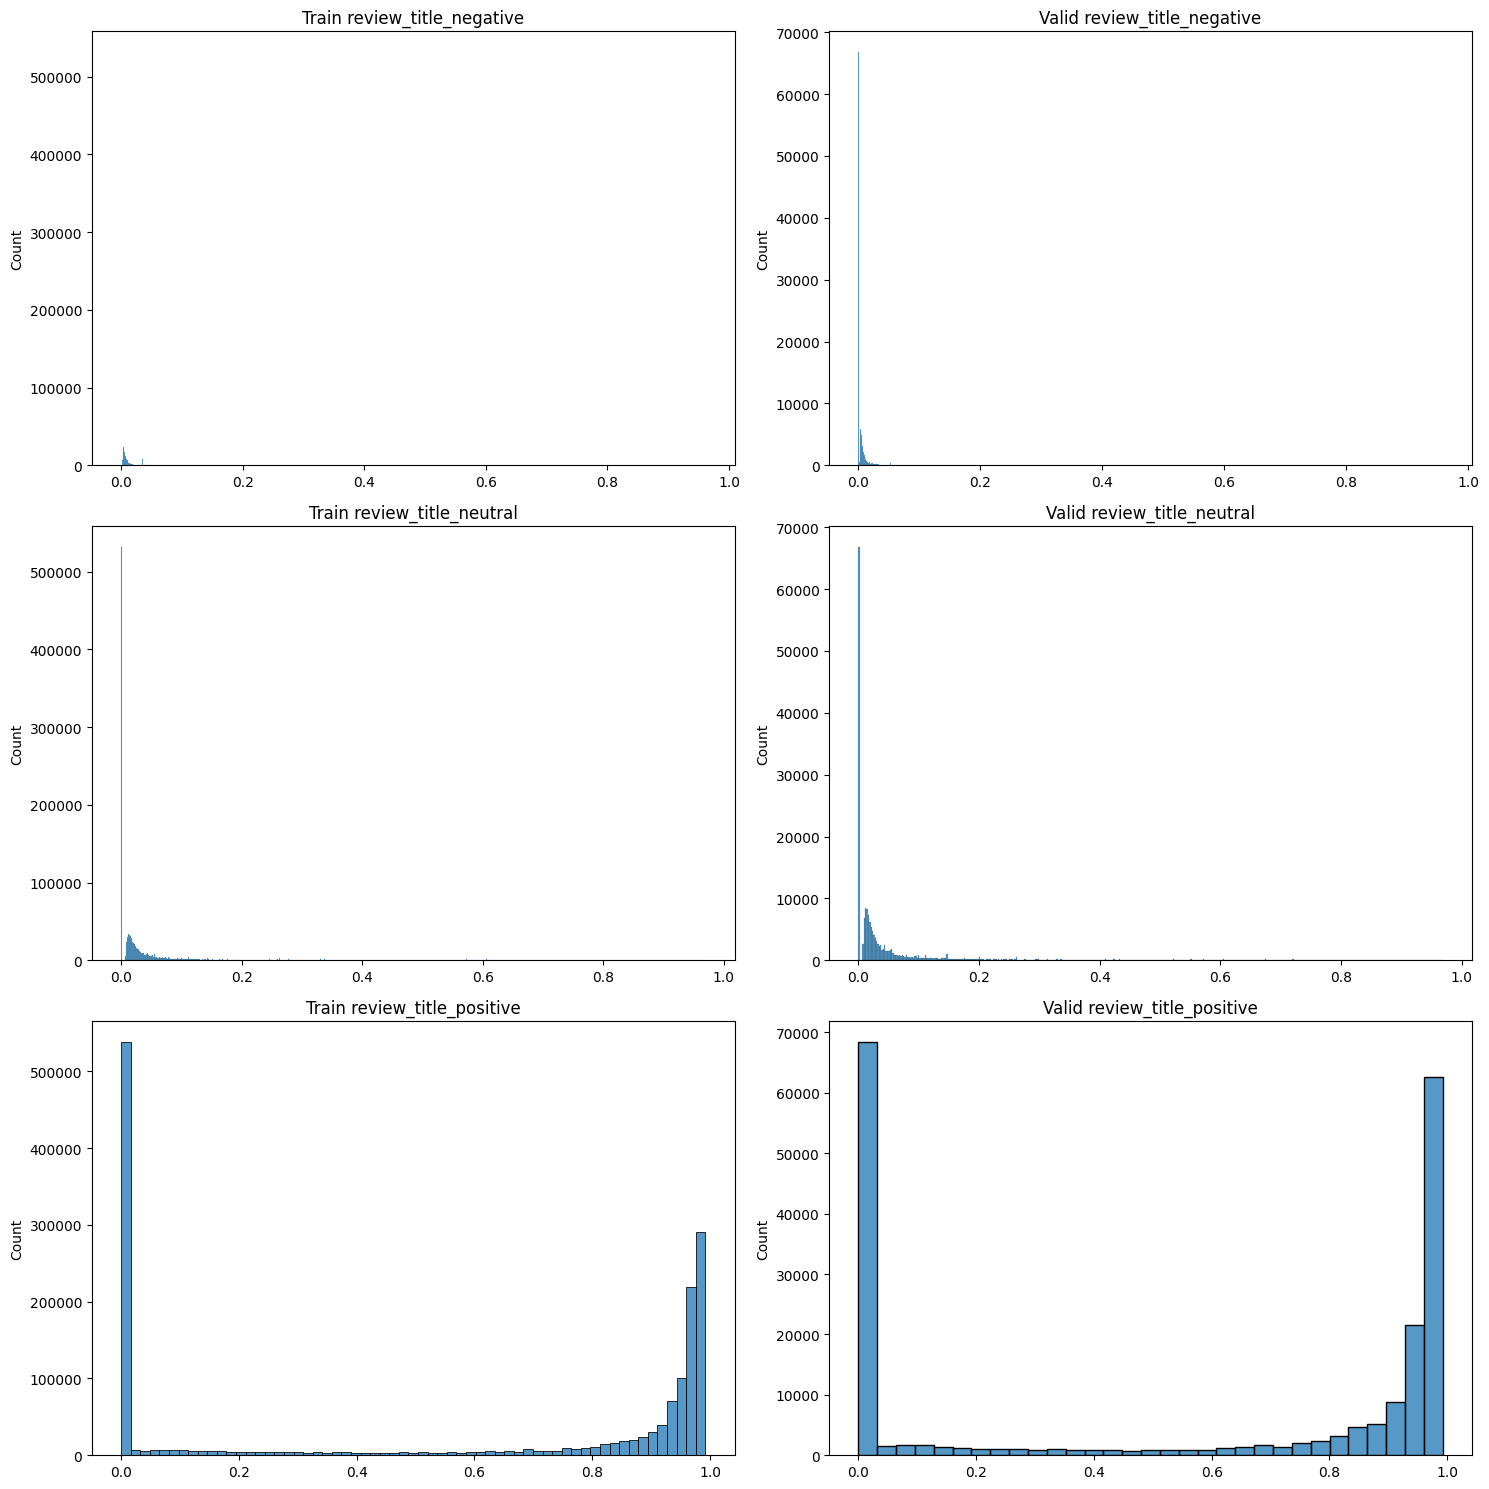

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

for i, col in enumerate(["review_title_negative", "review_title_neutral", "review_title_positive"]):
    sns.histplot(train_reviews[col], ax=ax[i, 0])
    sns.histplot(valid_reviews[col], ax=ax[i, 1])

    ax[i, 0].set_title(f"Train {col}")
    ax[i, 1].set_title(f"Valid {col}")

plt.tight_layout()
plt.show()

In [14]:
valid_reviews = (
    valid_reviews.with_columns(
        review_title_negative=pl.Series(valid_review_title_scores[:, 0]),
        review_title_neutral=pl.Series(valid_review_title_scores[:, 1]),
        review_title_positive=pl.Series(valid_review_title_scores[:, 2]),
    )
)

In [11]:
test_reviews = (
    test_reviews.with_columns(
        review_title_negative=pl.Series(test_review_title_scores[:, 0]),
        review_title_neutral=pl.Series(test_review_title_scores[:, 1]),
        review_title_positive=pl.Series(test_review_title_scores[:, 2]),
    )
)

In [13]:
# save
save_data_dir = "../../accommodation-reviews/preprocessed/"

if not Path(save_data_dir).exists():
    Path(save_data_dir).mkdir(parents=True, exist_ok=True)

train_reviews.write_csv(save_data_dir + "train_reviews.csv")
valid_reviews.write_csv(save_data_dir + "val_reviews.csv")
test_reviews.write_csv(save_data_dir + "test_reviews.csv")